# IMPORTANDO DATASET E BIBLIOTECAS

In [52]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
#Carregando dataset
df = pd.read_csv(r'C:\Users\felip\OneDrive\Documentos\Projetos Data Science\Estudantes\data\Student_performance_data _.csv')

# 4.LIMPEZA E PR√â-PROCESSAMENTO DOS DADOS

In [53]:
df.head()

StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196         2.0  
1             0  3.042915         1.0  
2             0  0.112602         4.0  
3             0  2.054218         3.0  
4             0  1.288061         4.0

Para come√ßar a limpeza, eu irei excluir a coluna, Student ID pois ela tem um valor para cada inst√¢ncia e n√£o ajudaria em nada no modelo, e a coluna Grade Class, pois ela causaria data leakage, visto que ela √© completamente derivada da GPA e seria artificial num modelo de predi√ß√£o, pois queremos prever o GPA sem conhecer a nota do aluno.

Al√©m disso, vamos arredondar a vari√°vel Study Time, para remover ru√≠do desnecess√°rio e o target, para melhor interpreta√ß√£o.

In [54]:
df.drop(columns=['StudentID', 'GradeClass'], axis=1, inplace=True)

In [55]:
df['GPA'] = df['GPA'].apply(lambda x: round(x,1))
df['StudyTimeWeekly'] = df['StudyTimeWeekly'].apply(lambda x: round(x,1))
df.head()

Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  Absences  \
0   17       1          0                  2             19.8         7   
1   18       0          0                  1             15.4         0   
2   15       0          2                  3              4.2        26   
3   17       1          0                  3             10.0        14   
4   17       1          0                  2              4.7        17   

   Tutoring  ParentalSupport  Extracurricular  Sports  Music  Volunteering  \
0         1                2                0       0      1             0   
1         0                1                0       0      0             0   
2         0                2                0       0      0             0   
3         0                3                1       0      0             0   
4         1                3                0       0      0             0   

   GPA  
0  2.9  
1  3.0  
2  0.1  
3  2.1  
4  1.3

Com isso feito, vamos separar os dados em treino e teste.

In [56]:
X = df.drop(columns='GPA', axis=1)
y = df['GPA']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(f'Os dados de treino t√™m {X_train.shape[0]} linhas, e os dados de teste t√™m {X_test.shape[0]} linhas')

Os dados de treino t√™m 1913 linhas, e os dados de teste t√™m 479 linhas


Para o pr√©-processamento, dividirei as features em 4 grupos (num√©ricas, ordinais, categ√≥ricas e bin√°rias) para tratamento mais espec√≠fico de cada feature.

As features bin√°rias n√£o precisar√£o ser tratadas.

In [73]:
numerical_features = ['Age',
                      'StudyTimeWeekly',
                      'Absences']

categorical_features = ['Gender',
                        'Ethnicity']

binary_features = ['Tutoring',
                   'Extracurricular',
                   'Sports',
                   'Music',
                   'Volunteering']

ordinal_features = ['ParentalEducation',
                    'ParentalSupport']

In [86]:
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

ord_pipe = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_features),
    ('cat', cat_pipe, categorical_features),
    ('ord', ord_pipe, ordinal_features),
    ('bin', 'passthrough', binary_features)
    ])

Farei um loop com alguns modelos de regress√£o, para decidir qual modelo funciona melhor.

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree' : DecisionTreeRegressor(),
    'RandomForestRegressor' : RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting' : GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost' : XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM' : LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "MSE": mse, "R¬≤": r2}
    df_results = pd.DataFrame(results).T
    df_results = df_results.sort_values(by="R¬≤", ascending=False)
print("\nRESULTADOS DOS MODELOS:\n")
print("-" * 50)

for model, scores in results.items():
    print(f"üîπ Modelo: {model}")
    print(f"   - Mean Absolute Error (MAE): {scores['MAE']:.3f}")
    print(f"   - Mean Squared Error (MSE): {scores['MSE']:.3f}")
    print(f"   - R¬≤ Score: {scores['R¬≤']:.3f}")
    print("-" * 50)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 16
[LightGBM] [Info] Start training from score 1.900836

RESULTADOS DOS MODELOS:

--------------------------------------------------
üîπ Modelo: LinearRegression
   - Mean Absolute Error (MAE): 0.157
   - Mean Squared Error (MSE): 0.039
   - R¬≤ Score: 0.953
--------------------------------------------------
üîπ Modelo: DecisionTree
   - Mean Absolute Error (MAE): 0.268
   - Mean Squared Error (MSE): 0.117
   - R¬≤ Score: 0.859
--------------------------------------------------
üîπ Modelo: RandomForestRegressor
   - Mean Absolute Error (MAE): 0.191
   - Mean Squared Error (MSE): 0.061
   - R¬≤ Score: 0.927
-----------------------------------

O melhor modelo foi o de Regress√£o Linear simples, o que indica que as nossas vari√°veis tem uma rela√ß√£o linear com o target.

# 5. MODELAGEM E AVALIA√á√ÉO DO MODELO

In [88]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
    ])
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'StudyTimeWeekly',
                                                   'Absences']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender', 'Ethnicity']),
                                                 ('ord',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['ParentalEducation',
                                                   'ParentalSupport']),
                                                 ('bin', 'passthrough',
                                                  ['Tutoring',
                                                   'Extracurricular', 'Sports',
                                                   'Music',
                                                   'Volunteering'])])),
                ('regressor', LinearRegression())])

In [89]:
y_pred = pipe.predict(X_test)

In [90]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae: .2f}")
print(f"MSE = {mse: .2f}")
print(f"RMSE = {rmse: .2f}")
print(f"R¬≤ = {r2: .2f}")

MAE =  0.16
MSE =  0.04
RMSE =  0.20
R¬≤ =  0.95


Nosso modelo tem um excelente poder preditivo, o erro m√©dio absoluto das previs√µes dele s√£o de 0.16 e considerando que o GPA varia de 0 a 4, s√£o valores incr√≠veis.

Um RMSE de 0.20, tamb√©m √© um valor interessante, pois mesmo penalizando erros grandes, o erro m√©dio continua pequeno.

E um R¬≤ de 95% tamb√©m √© impressionante, pois significa que 95% do target est√° sendo explicado pelas nossas vari√°veis.

Para avaliar nosso modelo visualmente, irei plotar um gr√°fico que compara as predi√ß√µes vs o resultado real dos dados de teste.

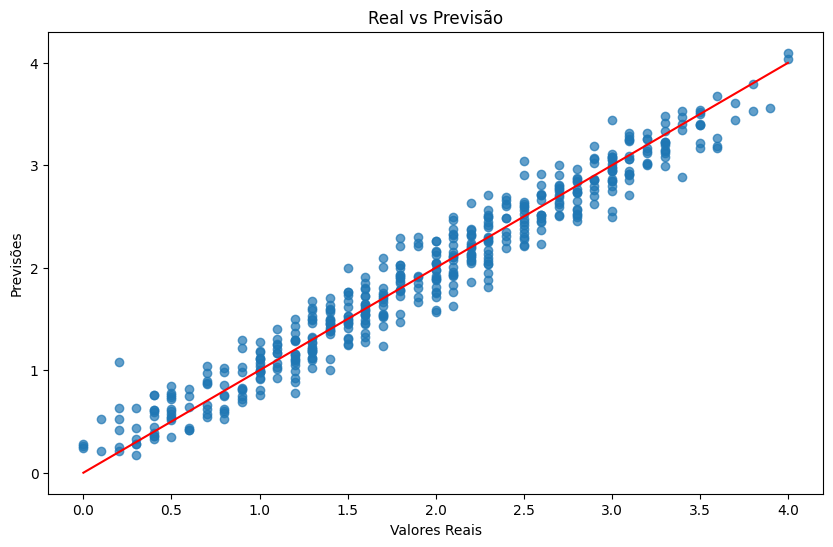

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Valores Reais")
plt.ylabel("Previs√µes")
plt.title("Real vs Previs√£o")
plt.show()

Interpreta√ß√£o do gr√°fico:
- A maioria dos pontos se alinha bem com a linha vermelha, o que √© um bom resultado.
- Apesar do alinhamento, os pontos tem uma ligeira dispers√£o vertical, que √© ampliada nos valores mais baixos e nos valores mais altos.
- O modelo n√£o tem um padr√£o de vi√©s evidente, como subestimar ou superestimar os valores, pois ele erra tanto para cima quanto para baixo.
- No final, √© um modelo satisfat√≥rio que pode ajudar imensamente os respons√°veis pela institui√ß√£o de ensino, a identificar notas ruins ou boas antes mesmo delas acontecerem e aprimorar o desempenho acad√™mico geral dos alunos.

 Para finalizar, veremos quais features s√£o mais importantes para a predi√ß√£o e aonde o col√©gio tem que direcionar seus esfor√ßos para uma maior nota dos alunos. Segue a f√≥rmula da regress√£o linear, para entendermos como faremos isso:

Explica√ß√£o da f√≥rmula da Regress√£o linear:

- y √© a vari√°vel dependente, tamb√©m chamda de target, e no nosso caso, o GPA.

- Œ≤0 √© o interceepto, valor de y quando todas as vari√°veis s√£o 0.

- Œ≤n √© o coeficiente da n-√©sima vari√°vel independente (feature), corresponde quanto a vari√°vel Xn influencia nosso target.

- e √© o res√≠duo, diferen√ßa entre o valor previsto pelo modelo e o valor observado.

Para saber quais features mais impactam o target, iremos checar os coeficientes de cada vari√°vel independente do nosso modelo.

In [92]:
feature_names = preprocessor.get_feature_names_out()

print(feature_names)

['num__Age' 'num__StudyTimeWeekly' 'num__Absences' 'cat__Gender_0'
 'cat__Gender_1' 'cat__Ethnicity_0' 'cat__Ethnicity_1' 'cat__Ethnicity_2'
 'cat__Ethnicity_3' 'ord__ParentalEducation' 'ord__ParentalSupport'
 'bin__Tutoring' 'bin__Extracurricular' 'bin__Sports' 'bin__Music'
 'bin__Volunteering']


In [96]:
regressor = pipe.named_steps['regressor']

feature_importances = np.abs(regressor.coef_)

feature_names = preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance':feature_importances
})

feature_importance.sort_values(by='importance', ascending=False)

feature  importance
2            num__Absences    0.844535
11           bin__Tutoring    0.259839
12    bin__Extracurricular    0.190330
13             bin__Sports    0.186969
1     num__StudyTimeWeekly    0.165479
14              bin__Music    0.154181
10    ord__ParentalSupport    0.147337
15       bin__Volunteering    0.008276
0                 num__Age    0.007317
5         cat__Ethnicity_0    0.006842
8         cat__Ethnicity_3    0.006539
4            cat__Gender_1    0.005869
3            cat__Gender_0    0.005869
6         cat__Ethnicity_1    0.000234
9   ord__ParentalEducation    0.000097
7         cat__Ethnicity_2    0.000068

A feature que mais impacta o target √© de fato o n√∫mero de faltas, como n√≥s suspeit√°vamos desde a an√°lise explorat√≥ria.
A segunda feature que mais impacta o target √© tutoring, que √© uma vari√°vel bin√°ria que indica se o aluno teve ou n√£o aulas particulares.

# 6. SOLU√á√ÉO PARA O PROBLEMA DE NEG√ìCIO

Com o nosso modelo preditivo, a escola j√° consegue identificar o baixo desempenho acad√™mico do aluno antes mesmo das notas finais dele. Permitindo criar solu√ß√µes personalizadas para cada aluno ou comunicar aos pais do respectivo aluno. Tamb√©m √© poss√≠vel tomar as seguintes solu√ß√µes preventivas mais generalizadas para aprimorar o desempenho acad√™mico m√©dio dos estudantes:

## Solu√ß√µes para reduzir o n√∫mero de faltas

Como vimos na nossa √∫ltima an√°lise, o n√∫mero de faltas √© o fator principal que modifica a nota final do aluno, e para reduz√≠-lo a fim de aumentar o desempenho final, podemos:
- Implementar um sistema de monitoramento para identificar alunos com alto n√∫mero de faltas.
- Enviar alertas para os pais e respons√°veis quando o n√∫mero de faltas atingir um certo limite.
- Oferecer suporte psicol√≥gico e social para alunos com faltas frequentes, identificando poss√≠veis causas(problemas de sa√∫de, familiares, etc.).
- Criar programas de recompensas para alunos com boa frequ√™ncia.

## N√≠vel de tutoria

Outro fator que impacta em grande quantitade na nota do aluno √© se ele tem ou n√£o tutoria, que eu irei entender como aulas particulares fora da escola. Para ajudarmos os alunos com dificuldade nas mat√©rias a terem um melhor desempenho nas provas, podemos:

- Oferecer sess√µes com monitores no contraturno das aulas, para os alunos tirarem as d√∫vidas que tiveram durante as aulas.
- Recomendar professores particulares de confian√ßa para os pais dos alunos contratarem.

## ATIVIDADES EXTRACURRICULARES

Outro fator que influencia positivamente o desempenho escolar do aluno, √© se ele est√° ou n√£o matriculado em atividades extracurriculares, principalmente atividades esportivas e musicais. Tendo isso em mente, podemos:

- Expandir o leque de atividades extracurriculares dispon√≠veis, incluindo esportes, m√∫sica, teatro, rob√≥tica, etc.
- Oferecer hor√°rios flex√≠veis para que os alunos possam participar dessas atividades sem prejudicar o tempo de estudo.
- Criar um sistema que recompense alunos que estiverem matriculados em atividades extracurriculares.